## Load packages

In [1]:
pacman::p_load(
  stringr,
  limma,
  dendsort,
  dendextend,
  RColorBrewer,
  pheatmap,
  dplyr,
  data.table,
  liger,
  ggplot2,
  factoextra,
  cluster,
  splines,
  seriation,
  magrittr,
  cetcolor,
  patchwork,
  tibble,
  ggrepel,
  scales,
  forcats
#   dendsort,
#   GGally,
#   knitr,
#   rio,
#   UpSetR,
#   matrixStats,
#   igraph,
#   Rfast
)

also installing the dependencies ‘ellipse’, ‘flashClust’, ‘leaps’, ‘scatterplot3d’, ‘polynom’, ‘FactoMineR’, ‘ggpubr’




The downloaded binary packages are in
	/var/folders/_p/36jhfrg52ld1643fftf08x740000gp/T//RtmprTAnd6/downloaded_packages



factoextra installed



The downloaded binary packages are in
	/var/folders/_p/36jhfrg52ld1643fftf08x740000gp/T//RtmprTAnd6/downloaded_packages



cetcolor installed


In [2]:
theme_set(theme_classic(base_size = 18) %+replace% theme(strip.background = element_blank(),
  # axis.line.y = element_line(colour = "black", size = 0.2),
  # axis.line.x = element_line(colour = "black", size = 0.2),
  axis.ticks   = element_line(colour = "black", size = 0.3),
  panel.border = element_rect(size = 0.3, fill = NA),
  axis.line    = element_blank(),
  plot.title   = element_text(size = 18, vjust = 2, hjust = 0.5)
))

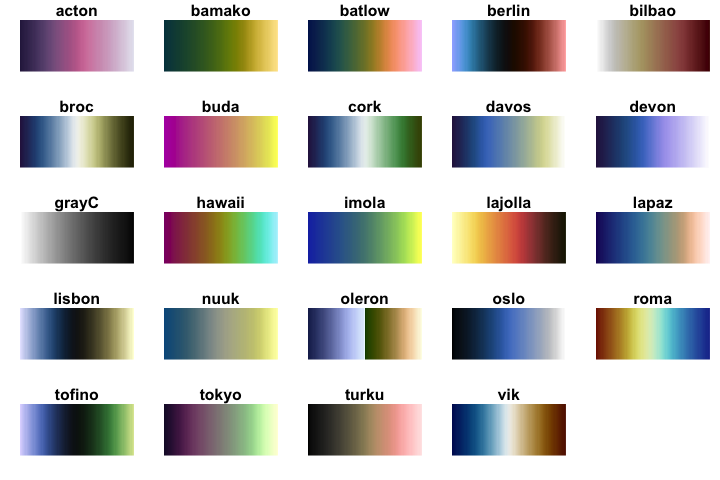

In [3]:
options(repr.plot.width = 6, repr.plot.height = 4)

scico::scico_palette_show()

## Load data

In [4]:
setwd("~/work/fibroblast_timecourse.partners")

load("data/shiny_rnaseq.rda")
meta <- meta[,!duplicated(colnames(meta))]

sirna <- new.env()
load("data/shiny_rnaseq-sirna.rda", envir = sirna)

In [5]:
source("R/002_helper_functions.R")
source("R/gg_qqplot.R")

sirnas <- c("CUX1", "ELF3", "LIFR", "STAT3", "STAT4")

meta_colors$sirna <- c(
  "Ctrl"  = "black",
  "CUX1"  = '#1B9E77',
  "STAT3" = '#D95F02',
  "STAT4" = '#7570B3',
  "ELF3"  = '#E7298A',
  "LIFR"  = '#66A61E'
)

meta_colors$Stimulation <- c(
  "None" = "grey50",
  "TNF (1)" = "#FEB24C",
  "TNF (1) + IL17 (1)" = "#E31A1C",
  "TNF (1) + IL17 (10)" = "#800026"
)

Check to see if *IL6* is present in the expression matrices:

In [6]:
names(gene_symbols[which(gene_symbols == "IL6")]) %in% rownames(log2tpm)
names(gene_symbols[which(gene_symbols == "IL6")]) %in% rownames(sirna$log2tpm)

[1] TRUE

[1] TRUE

Reformat the metadata for the dose-response gene expression data:

In [7]:
meta$donor       <- meta$Cell_Line
meta$time        <- meta$Time
meta$timefactor  <- meta$TimeFactor
meta$dose        <- meta$Dose
meta$dosefactor  <- meta$DoseFactor
meta$disease     <- meta$Disease
meta$stimulation <- meta$Stimulation

stopifnot(all(meta$Sample == colnames(log2tpm)))
rownames(meta)  <- colnames(log2tpm)
head(meta)

,Plate,Well,ID,Cell_Line,Stimulation,Time,Concentration,RNA_Prep,Disease,Conc_High,⋯,Age,RF,common_percent,donor,time,timefactor,dose,dosefactor,disease,stimulation
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<chr>,<lgl>,⋯,<chr>,<dbl>,<dbl>,<chr>,<int>,<fct>,<dbl>,<fct>,<chr>,<chr>
1,1,H11,2-A-2,RA1,TNF (1),2,20.0,1,RA,FALSE,⋯,M,55,0.9961115,RA1,2,2,0,0,RA,TNF (1)
10,1,A04,3-B-2,RA2,TNF (1) + IL17 (1),2,25.8,1,RA,FALSE,⋯,F,NA,0.9914784,RA2,2,2,1,1,RA,TNF (1) + IL17 (1)
100,1,D10,7-A-10,RA4,TNF (1),10,42.1,5,RA,TRUE,⋯,M,NA,0.9956979,RA4,10,10,0,0,RA,TNF (1)
101,1,B02,10-A-10,OA3,TNF (1),10,21.5,5,OA,FALSE,⋯,F,58,0.9966079,OA3,10,10,0,0,OA,TNF (1)
103,1,F04,14-A-10,OA1,TNF (1),10,21.9,5,OA,FALSE,⋯,M,NA,0.9929677,OA1,10,10,0,0,OA,TNF (1)
104,1,C08,15-A-10,OA2,TNF (1),10,26.6,5,OA,FALSE,⋯,M,NA,0.9965252,OA2,10,10,0,0,OA,TNF (1)


### Remove batch effects

Subtract the means of donors and plates to remove most of the batch effects.

Note: This means we can no longer look for differences between OA and RA, since all donors will be centered.

In [8]:
log2tpm_batch <- removeBatchEffect(x = log2tpm, batch = meta$donor, batch2 = meta$Plate)

### Gene set enrichment

In [9]:
load("data/gene_sets.rda")

In [10]:
clean_cols <- function(x) {
  colnames(x) <- str_replace_all(colnames(x), "[()]", "")
  colnames(x) <- str_replace_all(colnames(x), ":", "")
  colnames(x) <- str_replace_all(colnames(x), "DoseFactor", "d")
  colnames(x) <- str_replace_all(colnames(x), "DoseExposure", "d")
  colnames(x) <- str_replace_all(colnames(x), "TimeFactor", "t")
  colnames(x) <- str_replace_all(colnames(x), "TRUE", "1")
  return(x)
}

des1 <- clean_cols(with(
  meta,
  model.matrix(~ TimeFactor + DoseFactor)
))

head(des1)

Intercept,t2,t4,t6,t8,t10,t12,t18,t24,d1,d10
1,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0


In [11]:
hmark <- rbindlist(parallel::mclapply(
  mc.cores = 11,
  X = colnames(des1),
  FUN = function(contrast) {
    retval <- limma::camera(
      y        = log2tpm_batch,
      design   = des1,
      contrast = which(colnames(des1) == contrast),
      index    = ids2indices(
        gene.sets    = MSIGDB_H_ENSEMBL,
        identifiers  = rownames(log2tpm_batch),
        remove.empty = TRUE
      )
    )
    retval$contrast <- contrast
    retval$set      <- rownames(retval)
    retval$log10p   <- -log10(retval$PValue) * ifelse(retval$Direction == "Up", 1, -1)
    return(retval[order(rownames(retval)),])
  }
))

head(hmark)

hmark %>%
group_by(contrast) %>%
summarise(n = sum(PValue < 0.005 / nrow(hmark)))

NGenes,Direction,PValue,FDR,contrast,set,log10p
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
195,Up,1.775126e-14,9.861809e-14,Intercept,HALLMARK_ADIPOGENESIS,13.750771
158,Up,2.207288e-01,2.508282e-01,Intercept,HALLMARK_ALLOGRAFT_REJECTION,0.656141
95,Up,1.181511e-07,3.109239e-07,Intercept,HALLMARK_ANDROGEN_RESPONSE,6.927562
31,Up,2.425962e-03,3.912843e-03,Intercept,HALLMARK_ANGIOGENESIS,2.615116
178,Up,5.654234e-03,8.567022e-03,Intercept,HALLMARK_APICAL_JUNCTION,2.247626
35,Up,4.320272e-01,4.695947e-01,Intercept,HALLMARK_APICAL_SURFACE,0.364489


contrast,n
<chr>,<int>
d1,6
d10,6
Intercept,24
t10,13
t12,12
t18,11
t2,14
t24,9
t4,14


[1] 4.477121

NGenes,Direction,PValue,FDR,contrast,set,log10p,signif
<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<lgl>
158,Up,2.233838e-19,1.861532e-18,t6,HALLMARK_ALLOGRAFT_REJECTION,18.6509483,TRUE
149,Up,1.863523e-12,1.035290e-11,t6,HALLMARK_APOPTOSIS,11.7296653,TRUE
72,Up,2.420278e-01,3.781685e-01,t6,HALLMARK_CHOLESTEROL_HOMEOSTASIS,0.6161347,FALSE
171,Up,6.308206e-12,3.154103e-11,t6,HALLMARK_COMPLEMENT,11.2000941,TRUE
200,Down,1.610241e-12,1.006401e-11,t6,HALLMARK_E2F_TARGETS,-11.7931091,TRUE
198,Up,2.373385e-05,9.128403e-05,t6,HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION,4.6246318,TRUE


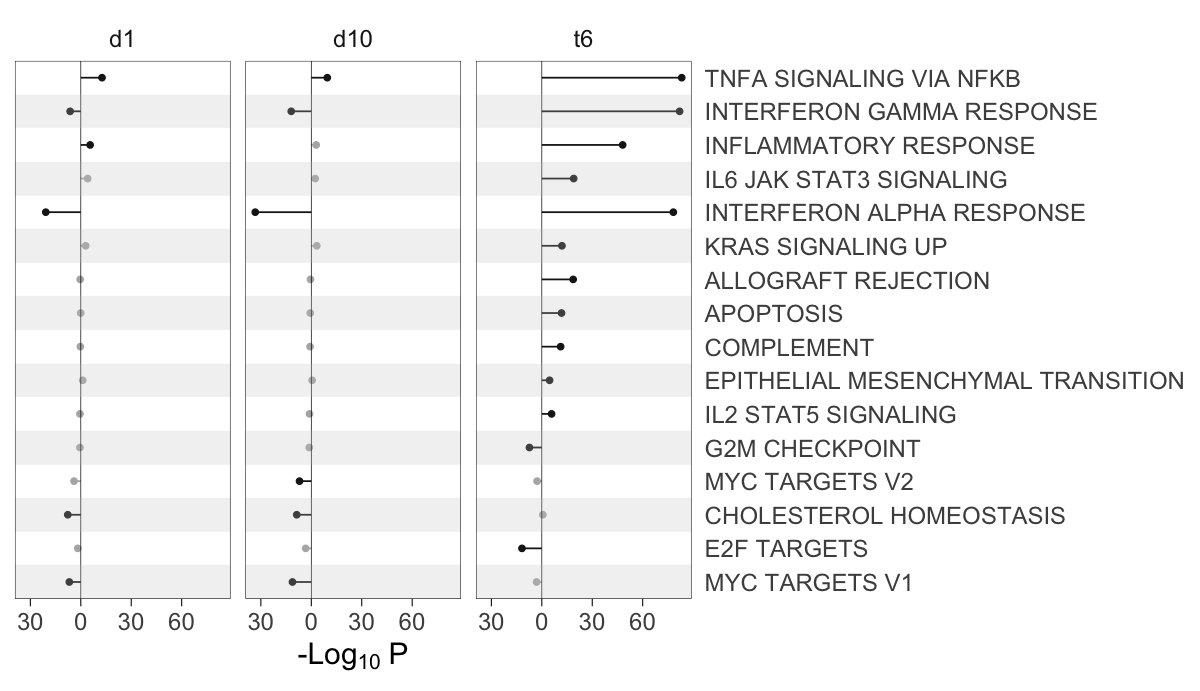

In [12]:
hmark_dat <- subset(hmark, contrast %in% c("t6", "d1", "d10"))

hmark_dat_bonf <- -log10(0.005 / nrow(hmark_dat))
hmark_dat_bonf

hmark_dat <- hmark_dat %>%
group_by(contrast) %>%
mutate(signif = abs(log10p) > hmark_dat_bonf) %>%
group_by(set) %>%
filter(sum(signif) >= 1)



head(hmark_dat)

hmark_dat$set <- factor(hmark_dat$set)
hmark_dat$set <- reorder(hmark_dat$set, hmark_dat$log10p)

n_gene_sets <- length(unique(hmark_dat$set))

labels_hmark <- function(x) {
  x <- str_replace_all(x, "HALLMARK_", "")
  x <- str_replace_all(x, "_", " ")
}

p <- ggplot(hmark_dat, aes(x = set, y = log10p, color = signif)) +
geom_point() +
geom_segment(mapping = aes(xend = set, yend = 0)) +
geom_hline(yintercept = 0, size = 0.2) +
scale_color_manual(values = c("TRUE" = "grey10", "FALSE" = "grey70")) +
scale_y_continuous(labels = abs) +
scale_x_discrete(position = "top", labels = labels_hmark, expand = c(0, 0.5)) +
facet_wrap(~ contrast) +
annotate(
 geom = "rect",
 ymin = -Inf, ymax = Inf,
 xmin = seq(0.5, n_gene_sets - 0.5, by = 2),
 xmax = seq(0.5, n_gene_sets - 0.5, by = 2) + 1,
 fill = "grey80",
 alpha = 0.25
) +
coord_flip() +
labs(x = NULL, y = bquote("-Log"[10]~"P")) +
theme(
  legend.position = "none",
  axis.ticks.y = element_blank()
)

options(repr.plot.width = 10, repr.plot.height = nrow(hmark_dat) * 0.12)

show_plot(p)

In [13]:
labels_hmark <- function(x) {
  allcaps <- str_to_lower(c("E2F", "G2M", "IL6", "JAK", "STAT3", "STAT5", "IL2", "KRAS", "MYC", "TNFA", "NFKB"))
  x <- str_replace_all(x, "HALLMARK_", "")
  x <- str_replace_all(x, "_", " ")
  x <- str_to_lower(x)
  xs <- str_split(x, " ")
  x <- sapply(xs, function(x) {
    for (i in 1:length(x)) {
      if (x[i] %in% allcaps) {
        x[i] <- str_to_upper(x[i])
      } else {
        x[i] <- str_to_title(x[i])
      }
    }
    str_flatten(x, " ")
  })
#   words <- str_split(x, " ")
#   ix <- sapply(words, nchar)
  x
}

# hmark_dat_dose$set %>% labels_hmark

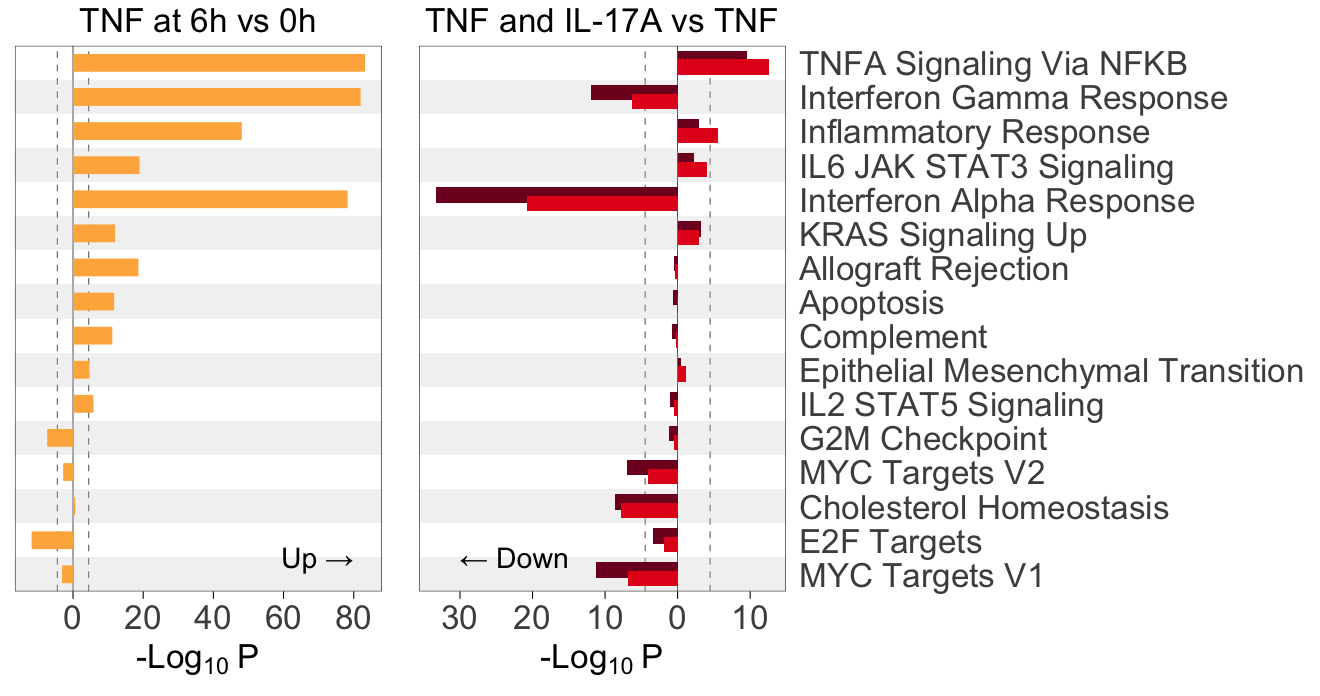

In [14]:
hmark_dat_dose <- hmark_dat %>%
filter(contrast %in% c("d1", "d10")) %>%
group_by(set) %>%
arrange(contrast) %>%
mutate(dose_diff = log10p[2] - log10p[1])

n_gene_sets <- length(unique(hmark_dat_dose$set))

p1 <- hmark_dat_dose %>%
ggplot(aes(x = set, y = log10p, fill = contrast)) +
geom_hline(yintercept = 0, size = 0.2) +
geom_hline(
  yintercept = c(hmark_dat_bonf, -hmark_dat_bonf),
  size = 0.2,
  linetype = 2
) +
# geom_segment(mapping = aes(xend = set, yend = 0), size = 0.2) +
# geom_point(shape = 21, size = 3) +
# geom_point(
#   shape = 21, size = 5, stroke = 0.2
# ) +
scale_fill_manual(
  name = NULL,
  labels = c("d1" = "1", "d10" = "10 ng/mL"),
  # values = c("d1" = "white", "d10" = "black")
  values = c(
    "d1" = meta_colors$Stimulation[["TNF (1) + IL17 (1)"]],
    "d10" = meta_colors$Stimulation[["TNF (1) + IL17 (10)"]]
  )
) +
# scale_color_manual(values = c("TRUE" = "grey10", "FALSE" = "grey70")) +
scale_y_continuous(labels = abs) +
scale_x_discrete(position = "top", labels = labels_hmark, expand = c(0, 0.5)) +
coord_flip() +
annotate(
 geom = "rect",
 ymin = -Inf, ymax = Inf,
 xmin = seq(0.5, n_gene_sets - 0.5, by = 2),
 xmax = seq(0.5, n_gene_sets - 0.5, by = 2) + 1,
 fill = "grey80",
 alpha = 0.25
) +
geom_col(size = 5, position = position_dodge(width = 0.5)) +
annotate(geom = "text", x = 1.5, y = -30, hjust = 0, size = 6, label = "← Down") +
labs(title = "TNF and IL-17A vs TNF", x = NULL, y = bquote("-Log"[10]~"P")) +
theme(
  plot.title = element_text(size = 20),
#   legend.position = "bottom",
  legend.position = "none",
  axis.ticks.y = element_blank(),
  axis.title = element_text(size = 20),
  axis.text = element_text(size = 20),
#   axis.text.y = element_blank(),
#   panel.grid.major.y = element_line(size = 0.2, color = "grey90"),
  panel.spacing = unit(1, "lines")
)

p2 <- hmark_dat %>%
filter(contrast == "t6") %>%
ggplot(aes(x = set, y = log10p)) + #, color = signif)) +
geom_hline(yintercept = 0, size = 0.2) +
geom_hline(
  yintercept = c(hmark_dat_bonf, -hmark_dat_bonf),
  size = 0.2,
  linetype = 2
) +
# geom_point(
#   shape = 21, size = 5, stroke = 0.2,
#   fill = meta_colors$Stimulation[["TNF (1)"]]
# ) +
annotate(
 geom = "rect",
 ymin = -Inf, ymax = Inf,
 xmin = seq(0.5, n_gene_sets - 0.5, by = 2),
 xmax = seq(0.5, n_gene_sets - 0.5, by = 2) + 1,
 fill = "grey80",
 alpha = 0.25
) +
geom_segment(
  mapping = aes(xend = set, yend = 0), size = 5, alpha = 1,
  color = meta_colors$Stimulation[["TNF (1)"]]
) +
annotate(geom = "text", x = 1.5, y = 80, hjust = 1, size = 6, label = "Up →") +
#scale_color_manual(values = c("TRUE" = "grey10", "FALSE" = "grey70")) +
scale_y_continuous(labels = abs) +
scale_x_discrete(position = "top", labels = labels_hmark, expand = c(0, 0.5)) +
#facet_wrap(~ contrast) +
coord_flip() +
labs(title = "TNF at 6h vs 0h", x = NULL, y = bquote("-Log"[10]~"P")) +
theme(
  plot.title = element_text(size = 20),
  legend.position = "none",
  axis.title = element_text(size = 20),
  axis.text.x = element_text(size = 20),
  axis.text.y = element_blank(),
  axis.ticks.y = element_blank()
#   panel.grid.major.y = element_line(size = 0.2, color = "grey90")
)


options(repr.plot.width = 11, repr.plot.height = 1 + n_gene_sets * 0.3)

show_plot(name = "hallmark-t6-d1-d10", p2 + p1)

In [15]:
cats <- readRDS("analysis/limma/cats.rds")

In [16]:
# hmark_dat %>% head %>% 
# mutate(
#   c1 = sum(MSIGDB_H_ENSEMBL[[set]] %in% cats[[1]]),
#   c2 = sum(MSIGDB_H_ENSEMBL[[set]] %in% cats[[2]]),
#   c3 = sum(MSIGDB_H_ENSEMBL[[set]] %in% cats[[3]]),
#   c4 = sum(MSIGDB_H_ENSEMBL[[set]] %in% cats[[4]]),
#   c5 = sum(MSIGDB_H_ENSEMBL[[set]] %in% cats[[5]])
# )

# hmark_dat %>% head

hmark_cats <- do.call(rbind, lapply(MSIGDB_H_ENSEMBL, function(x) {
  do.call(cbind, lapply(cats, function(y) sum(x %in% y)))
}))
rownames(hmark_cats) <- names(MSIGDB_H_ENSEMBL)
  
hmark_cats %>% head

,C1,C2,C3,C4,C5,None
HALLMARK_TNFA_SIGNALING_VIA_NFKB,6,13,59,6,2,112
HALLMARK_HYPOXIA,2,3,9,0,3,172
HALLMARK_CHOLESTEROL_HOMEOSTASIS,0,0,2,0,0,70
HALLMARK_MITOTIC_SPINDLE,0,0,2,0,12,186
HALLMARK_WNT_BETA_CATENIN_SIGNALING,0,0,1,0,0,35
HALLMARK_TGF_BETA_SIGNALING,0,0,3,0,1,49


In [17]:
fit1_top <- data.table::fread("gzip -cd analysis/limma/002_dose_limma_timefactor_dosefactor.tsv.gz")

[1] 97

[1] 96

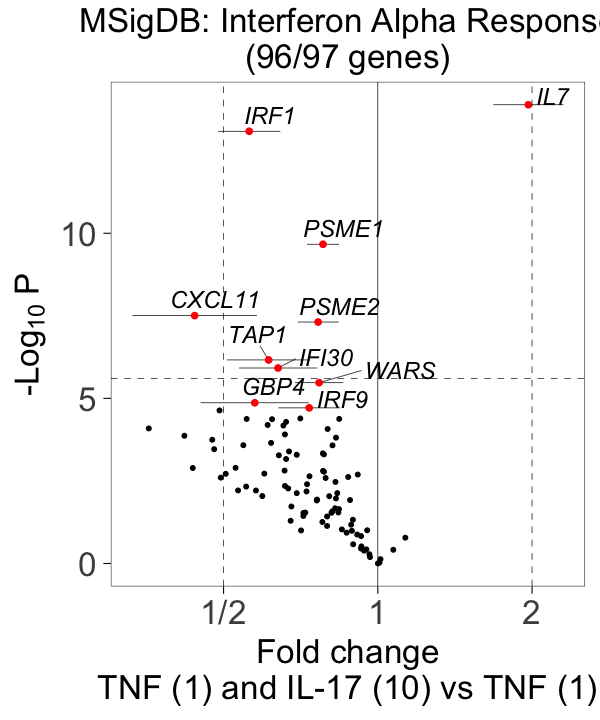

In [18]:
ifa_genes <- gene_symbols[MSIGDB_H_ENSEMBL[["HALLMARK_INTERFERON_ALPHA_RESPONSE"]]]
length(ifa_genes)

ifa_dat <- subset(fit1_top, ID %in% ifa_genes) %>%
filter(Coef %in% c("d10")) %>%
arrange(P.Value) %>% head(1000)
nrow(ifa_dat)

p <- ggplot(ifa_dat, aes(logFC, -log10(P.Value), label = ID)) +
geom_vline(
  xintercept = 0, size = 0.2
) +
geom_errorbarh(
  data = head(ifa_dat, 10),
  mapping = aes(xmin = CI.L, xmax = CI.R),
  size = 0.2,
  height = 0
) +
geom_hline(
  yintercept = -log10(0.05 / length(unique(fit1_top$ID))),
  linetype = 2, size = 0.2
) +
geom_vline(
  xintercept = log2(c(1/2, 2)), linetype = 2, size = 0.2
) +
geom_text_repel(
  data = head(ifa_dat, 10), segment.size = 0.2,
  fontface = "italic",
  nudge_y = 0.25, nudge_x = 0.1,
  size = 5
) +
geom_point(size = 1) +
geom_point(data = head(ifa_dat, 10), size = 1.5, color = "red") +
scale_x_continuous(labels = function(x) fractional::fractional(2^x)) +
labs(
  y = bquote("-Log"[10]~"P"),
  x = "Fold change\nTNF (1) and IL-17 (10) vs TNF (1)",
  title = sprintf("MSigDB: Interferon Alpha Response\n(%s/%s genes)", comma(nrow(ifa_dat)), comma(length(ifa_genes)))
) +
theme(
  plot.title = element_text(size = 20),
  axis.text = element_text(size = 20),
  axis.title = element_text(size = 20)
)
                   
# options(repr.plot.width = 6, repr.plot.height = 6)
# show_plot(name = "interferon-alpha-volcano", p)
                   
options(repr.plot.width = 5, repr.plot.height = 6)
show_plot(name = "hallmark-e2f-targets-volcano", p)

[1] 10

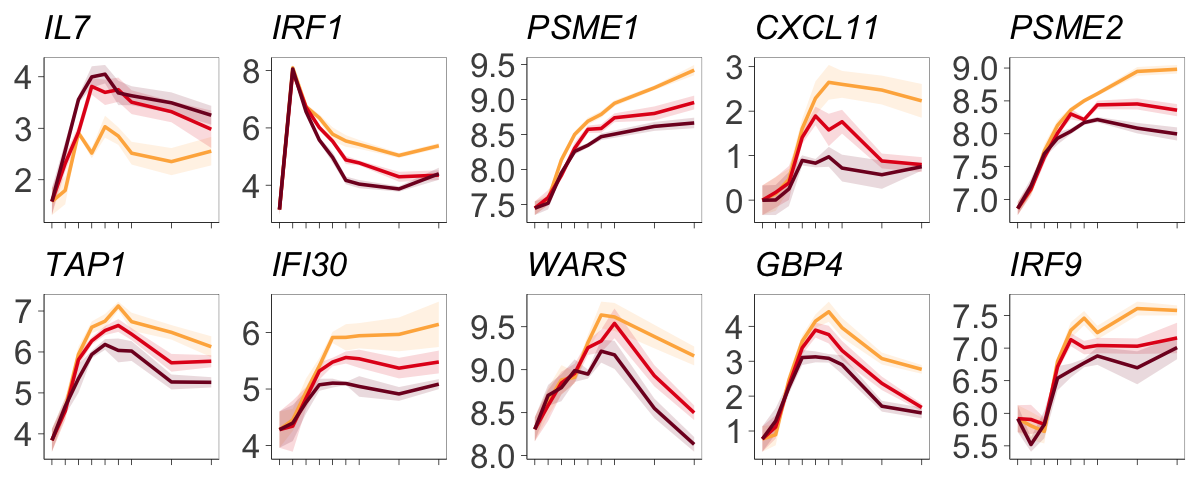

In [19]:
these_genes <- (subset(fit1_top, ID %in% ifa_genes) %>%
filter(Coef %in% c("d10")) %>%
arrange(P.Value) %>% head(10) %>%
# filter(Coef %in% c("d1", "d10", "t6")) %>%
# arrange(d10) %>% head %>%
# group_by(ID) %>%
# filter(sum(signif) > 0) %>%
# filter(all(adj.P.Val < 0.05)) %>%
dplyr::select(ID) %>%
unique)[[1]]

length(these_genes)

# plots <- lapply(these_genes, function(this_gene) {
#   p <- plot_gene_by_stimulation(this_gene, meta = meta, log2tpm = log2tpm_batch) +
#   theme(
#     legend.position = "none",
#     axis.title = element_blank(),
# #     axis.text.x = element_blank(),
#     axis.text.y = element_text(size = 20),
#     plot.title = element_text(size = 20, face = "italic")
#   )
#   p
# })

# options(repr.plot.width = 5 * 1.5, repr.plot.height = 2 * 2)

# show_plot(name = "interferon-alpha-genes",
#   wrap_plots(plots, ncol = 5)
# )

plots <- lapply(these_genes, function(this_gene) {
  p <- plot_gene_by_stimulation(this_gene, meta = meta, log2tpm = log2tpm_batch) +
  theme(
    legend.position = "none",
    axis.title = element_blank(),
    axis.text.x = element_blank(),
    axis.text.y = element_text(size = 20),
    plot.title = element_text(size = 20, face = "italic")
  )
  p
})

options(repr.plot.width = 5 * 2, repr.plot.height = 2 * 2)

show_plot(name = "hallmark-interferon-alpha-genes",
  wrap_plots(plots, ncol = 5)
)

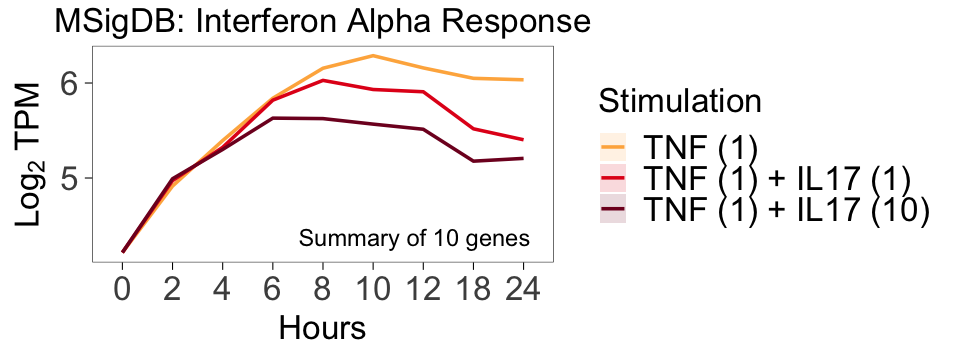

In [20]:

p <- plot_geneset_by_stimulation(
  geneset = these_genes,#[!these_genes %in% c("IL7")],
  meta = meta,
  log2tpm = log2tpm_batch,
  ci = 0.01
) +
labs(title = "MSigDB: Interferon Alpha Response") +
theme(
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 20),
  plot.title = element_text(size = 20),
  axis.title = element_text(size = 20),
  axis.text = element_text(size = 20)
)

options(repr.plot.width = 8, repr.plot.height = 3)

show_plot(name = "interferon-alpha-lines", p)

[1] 200

[1] 189

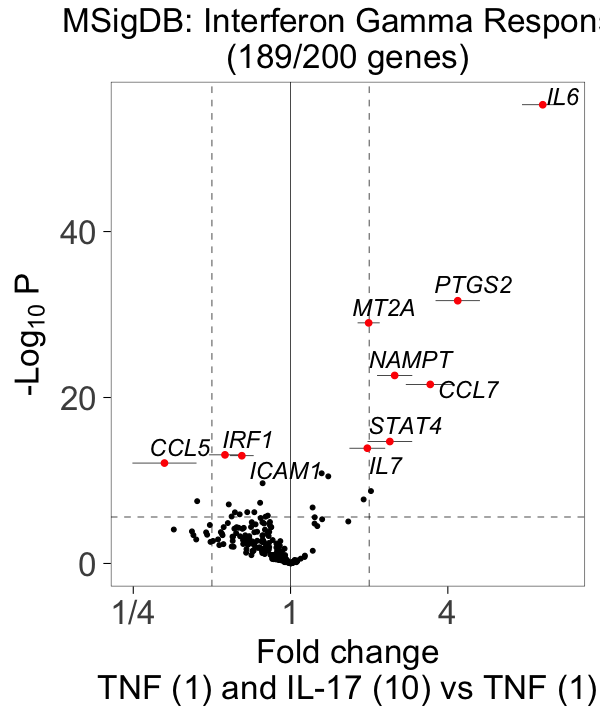

In [21]:
ifa_genes <- gene_symbols[MSIGDB_H_ENSEMBL[["HALLMARK_INTERFERON_GAMMA_RESPONSE"]]]
length(ifa_genes)

ifa_dat <- subset(fit1_top, ID %in% ifa_genes) %>%
filter(Coef %in% c("d10")) %>%
arrange(P.Value) %>% head(1000)
nrow(ifa_dat)

p <- ggplot(ifa_dat, aes(logFC, -log10(P.Value), label = ID)) +
geom_vline(
  xintercept = 0, size = 0.2
) +
geom_errorbarh(
  data = head(ifa_dat, 10),
  mapping = aes(xmin = CI.L, xmax = CI.R),
  size = 0.2,
  height = 0
) +
geom_hline(
  yintercept = -log10(0.05 / length(unique(fit1_top$ID))),
  linetype = 2, size = 0.2
) +
geom_vline(
  xintercept = log2(c(1/2, 2)), linetype = 2, size = 0.2
) +
geom_text_repel(
  data = head(ifa_dat, 10), segment.size = 0.2,
  fontface = "italic",
  nudge_y = 0.25, nudge_x = 0.1,
  size = 5
) +
geom_point(size = 1) +
geom_point(data = head(ifa_dat, 10), size = 1.5, color = "red") +
scale_x_continuous(labels = function(x) fractional::fractional(2^x)) +
labs(
  y = bquote("-Log"[10]~"P"),
  x = "Fold change\nTNF (1) and IL-17 (10) vs TNF (1)",
  title = sprintf("MSigDB: Interferon Gamma Response\n(%s/%s genes)", comma(nrow(ifa_dat)), comma(length(ifa_genes)))
) +
theme(
  plot.title = element_text(size = 20),
  axis.text = element_text(size = 20),
  axis.title = element_text(size = 20)
)
                   
# options(repr.plot.width = 6, repr.plot.height = 6)
# show_plot(name = "interferon-alpha-volcano", p)
                   
options(repr.plot.width = 5, repr.plot.height = 6)
show_plot(name = "hallmark-interferon-gamma-volcano", p)

[1] 10

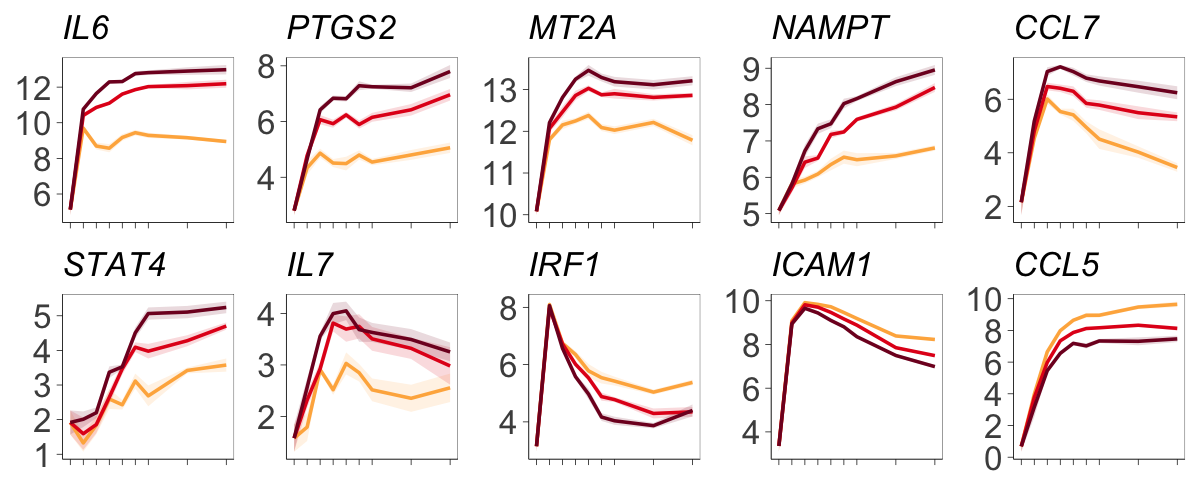

In [22]:
these_genes <- (subset(fit1_top, ID %in% ifa_genes) %>%
filter(Coef %in% c("d10")) %>%
arrange(P.Value) %>% head(10) %>%
# filter(Coef %in% c("d1", "d10", "t6")) %>%
# arrange(d10) %>% head %>%
# group_by(ID) %>%
# filter(sum(signif) > 0) %>%
# filter(all(adj.P.Val < 0.05)) %>%
dplyr::select(ID) %>%
unique)[[1]]

length(these_genes)

# plots <- lapply(these_genes, function(this_gene) {
#   p <- plot_gene_by_stimulation(this_gene, meta = meta, log2tpm = log2tpm_batch) +
#   theme(
#     legend.position = "none",
#     axis.title = element_blank(),
# #     axis.text.x = element_blank(),
#     axis.text.y = element_text(size = 20),
#     plot.title = element_text(size = 20, face = "italic")
#   )
#   p
# })

# options(repr.plot.width = 5 * 1.5, repr.plot.height = 2 * 2)

# show_plot(name = "interferon-alpha-genes",
#   wrap_plots(plots, ncol = 5)
# )

plots <- lapply(these_genes, function(this_gene) {
  p <- plot_gene_by_stimulation(this_gene, meta = meta, log2tpm = log2tpm_batch) +
  theme(
    legend.position = "none",
    axis.title = element_blank(),
    axis.text.x = element_blank(),
    axis.text.y = element_text(size = 20),
    plot.title = element_text(size = 20, face = "italic")
  )
  p
})

options(repr.plot.width = 5 * 2, repr.plot.height = 2 * 2)

show_plot(name = "hallmark-interferon-gamma-genes",
  wrap_plots(plots, ncol = 5)
)

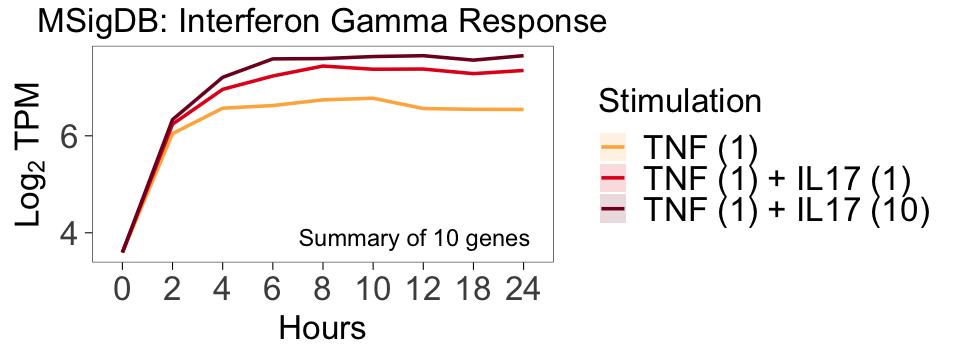

In [23]:

p <- plot_geneset_by_stimulation(
  geneset = these_genes,#[!these_genes %in% c("IL7")],
  meta = meta,
  log2tpm = log2tpm_batch,
  ci = 0.01
) +
labs(title = "MSigDB: Interferon Gamma Response") +
theme(
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 20),
  plot.title = element_text(size = 20),
  axis.title = element_text(size = 20),
  axis.text = element_text(size = 20)
)

options(repr.plot.width = 8, repr.plot.height = 3)

show_plot(name = "interferon-gamma-lines", p)

**C3** motif gene sets based on conserved cis-regulatory motifs from a comparative analysis of the human, mouse, rate and dog genomes.

In [21]:
c3 <- rbindlist(parallel::mclapply(
  mc.cores = 10,
  X = colnames(des1),
  FUN = function(contrast) {
    retval <- limma::camera(
      y        = log2tpm_batch,
      design   = des1,
      contrast = which(colnames(des1) == contrast),
      index    = ids2indices(
        gene.sets    = MSIGDB_C3_ENSEMBL,
        identifiers  = rownames(log2tpm_batch),
        remove.empty = TRUE
      )
    )
    retval$contrast <- contrast
    retval$set      <- rownames(retval)
    retval$log10p   <- -log10(retval$PValue) * ifelse(retval$Direction == "Up", 1, -1)
    return(retval[order(rownames(retval)),])
  }
))

head(c3)

c3 %>%
group_by(contrast) %>%
summarise(n = sum(PValue < 0.005 / nrow(c3)))

NGenes,Direction,PValue,FDR,contrast,set,log10p
102,Up,1.360505e-03,0.0046494930,Intercept,"AAACCAC,MIR-140",2.866300
112,Up,9.057134e-03,0.0204366095,Intercept,"AAAGGAT,MIR-501",2.043009
163,Up,8.471481e-02,0.1274342379,Intercept,AAANWWTGC_UNKNOWN,1.072041
134,Up,5.354079e-05,0.0003624299,Intercept,"AACATTC,MIR-409-3P",4.271315
12,Up,1.101165e-02,0.0233622854,Intercept,"AACGGTT,MIR-451",1.958148
90,Up,5.783730e-03,0.0145419487,Intercept,"AACTGAC,MIR-223",2.237792


contrast,n
d1,0
d10,0
Intercept,20
t10,3
t12,3
t18,3
t2,2
t24,3
t4,3
t6,3


[1] 5.324694

NGenes,Direction,PValue,FDR,contrast,set,log10p,signif
120,Up,6.899405e-15,2.428590e-12,t6,GGGNNTTTCC_V$NFKB_Q6_01,14.1611884,TRUE
171,Up,3.317624e-14,5.839018e-12,t6,STTTCRNTTT_V$IRF_Q6,13.4791729,TRUE
20,Up,4.264151e-08,5.003270e-06,t6,V$STAT3_01,7.3701675,TRUE
120,Down,7.907275e-02,8.020086e-01,d1,GGGNNTTTCC_V$NFKB_Q6_01,-1.1019732,FALSE
171,Down,4.510184e-03,7.937923e-01,d1,STTTCRNTTT_V$IRF_Q6,-2.3458058,FALSE
20,Down,3.321129e-01,8.628727e-01,d1,V$STAT3_01,-0.4787143,FALSE


[1] 3

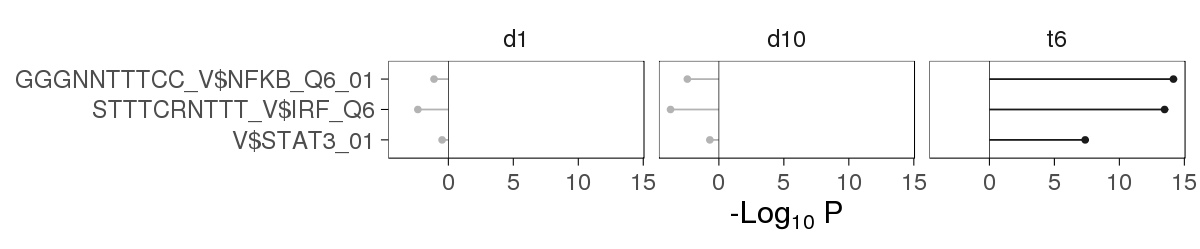

In [22]:
c3_dat <- subset(c3, contrast %in% c("t6", "d1", "d10"))

c3_dat_bonf <- -log10(0.005 / nrow(c3_dat))
c3_dat_bonf

c3_dat <- c3_dat %>%
group_by(contrast) %>%
mutate(signif = abs(log10p) > c3_dat_bonf) %>%
group_by(set) %>%
filter(sum(signif) >= 1)

options(repr.plot.width = 10, repr.plot.height = 1 + nrow(c3_dat) * 0.12)

head(c3_dat)
length(unique(c3_dat$set))

c3_dat$set <- factor(c3_dat$set)
c3_dat$set <- reorder(c3_dat$set, c3_dat$log10p)

p <- ggplot(c3_dat, aes(x = set, y = log10p, color = signif)) +
geom_point() +
geom_segment(mapping = aes(xend = set, yend = 0)) +
geom_hline(yintercept = 0, size = 0.2) +
scale_color_manual(values = c("TRUE" = "grey10", "FALSE" = "grey70")) +
scale_y_continuous(labels = abs) +
scale_x_discrete(labels = function(x) substr(x, 1, 30)) +
facet_wrap(~ contrast) +
coord_flip() +
labs(x = NULL, y = bquote("-Log"[10]~"P")) +
theme(legend.position = "none")

show_plot(p)

[1] 200

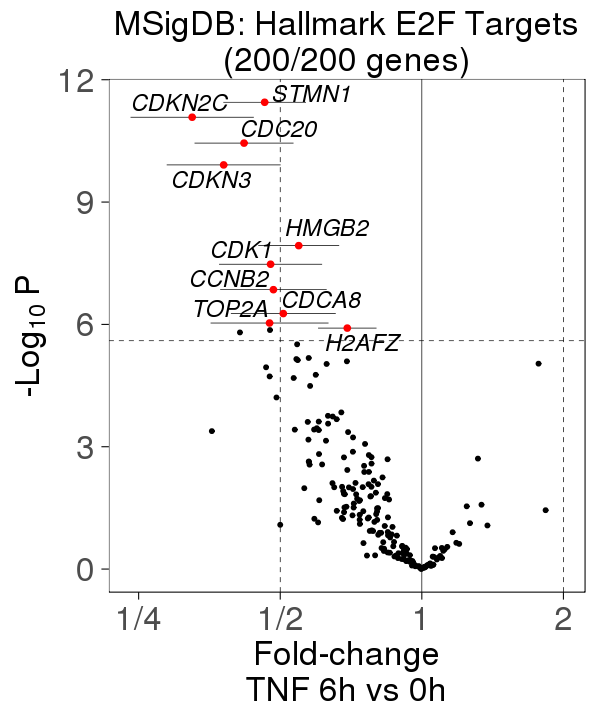

In [56]:
ifa_genes <- gene_symbols[MSIGDB_H_ENSEMBL[["HALLMARK_E2F_TARGETS"]]]
length(ifa_genes)

ifa_dat <- subset(fit1_top, ID %in% ifa_genes) %>%
filter(Coef %in% c("t6")) %>%
arrange(P.Value) %>%
head(1000) %>%
mutate(repel = ifelse(row_number(P.Value) <= 10, ID, ""))


p <- ggplot(ifa_dat, aes(logFC, -log10(P.Value), label = repel)) +
geom_vline(
  xintercept = 0, size = 0.2
) +
geom_errorbarh(
  data = head(ifa_dat, 10),
  mapping = aes(xmin = CI.L, xmax = CI.R),
  size = 0.2,
  height = 0
) +
geom_hline(
  yintercept = -log10(0.05 / length(unique(fit1_top$ID))),
  linetype = 2, size = 0.2
) +
geom_vline(
  xintercept = log2(c(1/2, 2)), linetype = 2, size = 0.2
) +
geom_text_repel(
  # data = head(ifa_dat, 10),
  size = 5,
  segment.size = 0.2,
  fontface = "italic"
) +
geom_point(size = 1) +
geom_point(data = head(ifa_dat, 10), size = 1.5, color = "red") +
scale_x_continuous(labels = function(x) fractional::fractional(2^x)) +
labs(
  x = "Fold-change\nTNF 6h vs 0h",
  y = bquote("-Log"[10]~"P"),
  # caption = "Response to TNF at 6h",
  title = sprintf("MSigDB: Hallmark E2F Targets\n(%s/%s genes)", comma(nrow(ifa_dat)), comma(length(ifa_genes)))
) +
theme(
  axis.text = element_text(size = 20),
  axis.title = element_text(size = 20),
  plot.title = element_text(size = 20)
)
                   
options(repr.plot.width = 5, repr.plot.height = 6)
show_plot(name = "hallmark-e2f-targets-volcano", p)

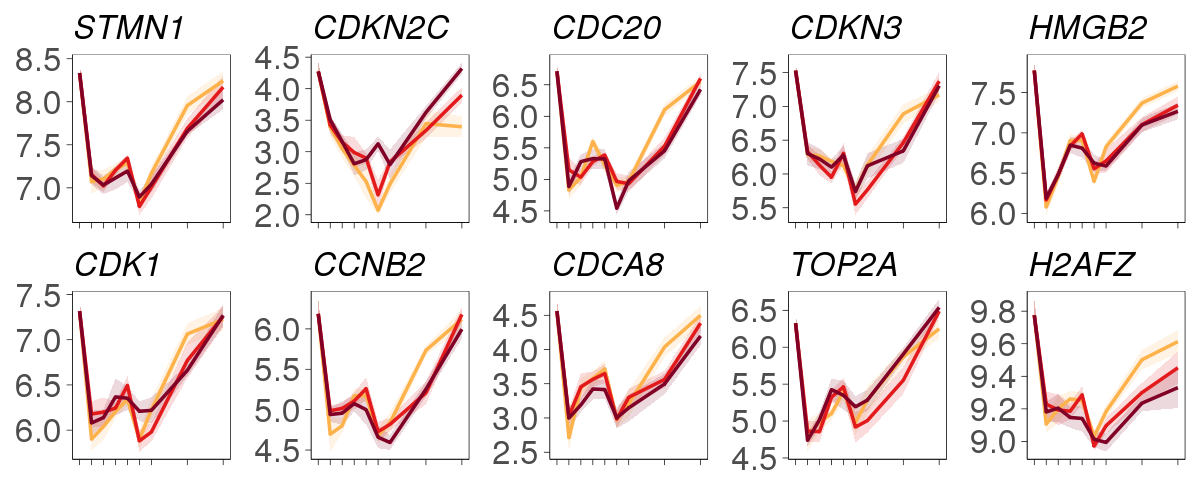

In [37]:
x <- unique(ifa_dat$repel)
x <- x[nchar(x) > 1]

# plot_these_genes(x, res = 300)

plots <- lapply(x, function(this_gene) {
  p <- plot_gene_by_stimulation(this_gene, meta = meta, log2tpm = log2tpm_batch) +
  theme(
    legend.position = "none",
    axis.title = element_blank(),
    axis.text.x = element_blank(),
    axis.text.y = element_text(size = 20),
    plot.title = element_text(size = 20, face = "italic")
  )
  p
})

options(repr.plot.width = 5 * 2, repr.plot.height = 2 * 2)

show_plot(name = "hallmark-e2f-targets-genes",
  wrap_plots(plots, ncol = 5)
)

[1] 161

[1] 149

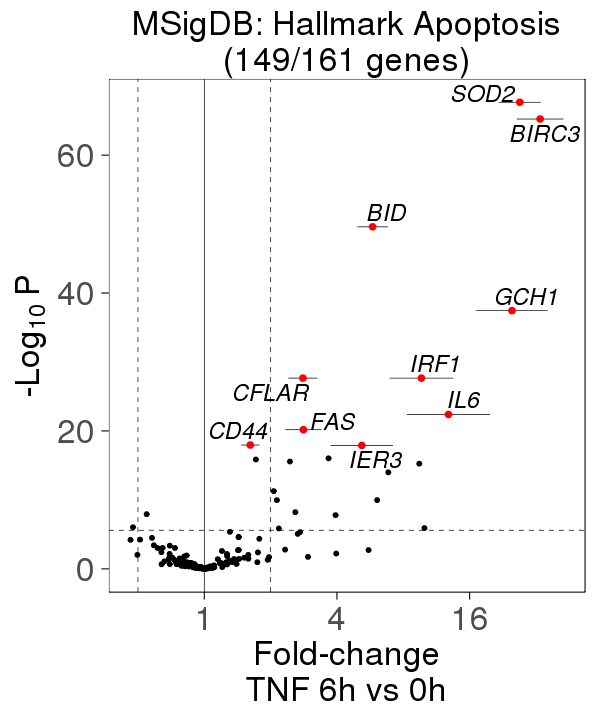

In [57]:
ifa_genes <- gene_symbols[MSIGDB_H_ENSEMBL[["HALLMARK_APOPTOSIS"]]]
length(ifa_genes)

ifa_dat <- subset(fit1_top, ID %in% ifa_genes) %>%
filter(Coef %in% c("t6")) %>%
arrange(P.Value) %>%
head(1000) %>%
mutate(repel = ifelse(row_number(P.Value) <= 10, ID, ""))

nrow(ifa_dat)


p <- ggplot(ifa_dat, aes(logFC, -log10(P.Value), label = repel)) +
geom_vline(
  xintercept = 0, size = 0.2
) +
geom_errorbarh(
  data = head(ifa_dat, 10),
  mapping = aes(xmin = CI.L, xmax = CI.R),
  size = 0.2,
  height = 0
) +
geom_hline(
  yintercept = -log10(0.05 / length(unique(fit1_top$ID))),
  linetype = 2, size = 0.2
) +
geom_vline(
  xintercept = log2(c(1/2, 2)), linetype = 2, size = 0.2
) +
geom_text_repel(
  # data = head(ifa_dat, 10),
  size = 5,
  segment.size = 0.2,
  fontface = "italic"
) +
geom_point(size = 1) +
geom_point(data = head(ifa_dat, 10), size = 1.5, color = "red") +
scale_x_continuous(labels = function(x) fractional::fractional(2^x)) +
labs(
  x = "Fold-change\nTNF 6h vs 0h",
  y = bquote("-Log"[10]~"P"),
#   title = "Response to TNF at 6h",
  title = sprintf("MSigDB: Hallmark Apoptosis\n(%s/%s genes)", comma(nrow(ifa_dat)), comma(length(ifa_genes)))
) +
theme(
  axis.text = element_text(size = 20),
  axis.title = element_text(size = 20),
  plot.title = element_text(size = 20)
)
                   
options(repr.plot.width = 5, repr.plot.height = 6)
show_plot(name = "hallmark-apoptosis-volcano", p)

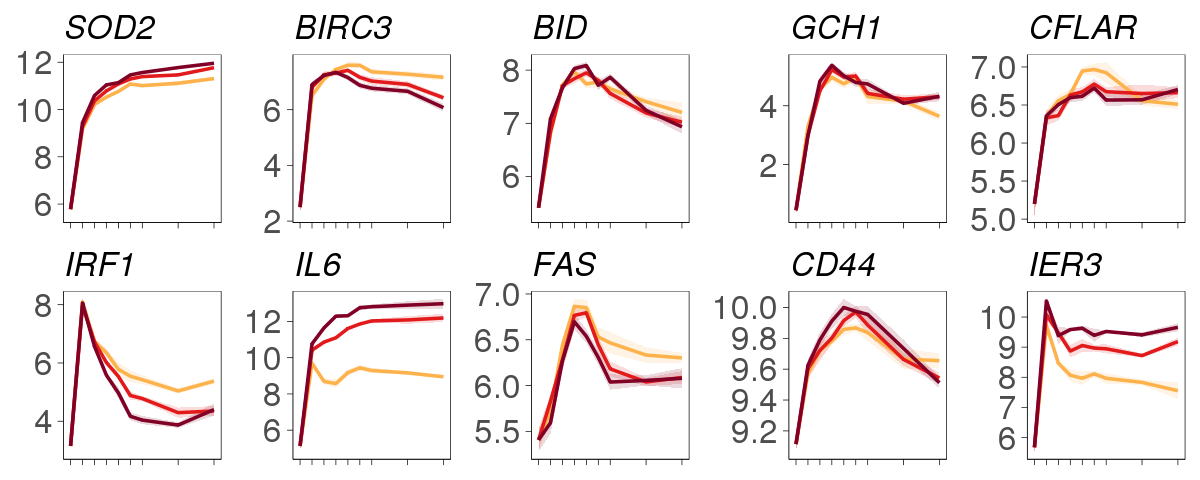

In [39]:
x <- unique(ifa_dat$repel)
x <- x[nchar(x) > 1]

# plot_these_genes(x, res = 300)

plots <- lapply(x, function(this_gene) {
  p <- plot_gene_by_stimulation(this_gene, meta = meta, log2tpm = log2tpm_batch) +
  theme(
    legend.position = "none",
    axis.title = element_blank(),
    axis.text.x = element_blank(),
    axis.text.y = element_text(size = 20),
    plot.title = element_text(size = 20, face = "italic")
  )
  p
})

options(repr.plot.width = 5 * 2, repr.plot.height = 2 * 2)

show_plot(name = "hallmark-apoptosis-genes",
  wrap_plots(plots, ncol = 5)
)

In [27]:
cat(head(ifa_dat, 10)$ID)

SOD2 BIRC3 BID GCH1 CFLAR IRF1 IL6 FAS CD44 IER3